## Import libraries

In [2]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab 
from matplotlib.offsetbox import AnchoredText
import seaborn as sns
from datetime import datetime, date

## Define functions

In [4]:
def cleanspaces(text):
    #used to clean empty spaces from strings
    text = re.sub('\s+', '', text)
    return text

def getkw(text):
    #used to get kW value from string
    patternls = r'(\d{1,5})\s?[Ll][/][Ss]'
    patternkw = r'(\d{1,3})\s?[Kk][Ww]'
    
    flags = re.IGNORECASE
    outputlstext = re.findall(patternls, text, flags = flags)
    outputls = [float(i) for i in outputlstext]
    outputkwtext = re.findall(patternkw, text, flags = flags)
    outputkw = [float(i) for i in outputkwtext]
          
    if len(outputkw) == 0:
        if len(outputls) != 0:
            outputmaxkw = max(outputls)/50
        else:
            outputmaxkw = 0
    else:
        outputmaxkw = max(outputkw)
        
    return outputmaxkw

def getls(text):
    #used to get airflow value from string
    patternls = r'(\d{1,5})\s?[Ll][/][Ss]'
    patternkw = r'(\d{1,3})\s?[Kk][Ww]'
    
    flags = re.IGNORECASE
    outputlstext = re.findall(patternls, text, flags = flags)
    outputls = [float(i) for i in outputlstext]
    outputkwtext = re.findall(patternkw, text, flags = flags)
    outputkw = [float(i) for i in outputkwtext]
    
    if len(outputls) == 0:
        if len(outputkw) != 0:
            outputmaxls = max(outputkw)*50
        else:
            outputmaxls = 0
    else:
        outputmaxls = max(outputls)
        
    return outputmaxls   

def getecon(text):
    #used to get econmy cycle value from string
    patternecon = r'econ'
    flags = re.IGNORECASE
    outputecontext = re.findall(patternecon, text, flags = flags)      
    if len(outputecontext) >= 1:
        outputecon = 1
    else:
        outputecon = 0
    return outputecon

def printhist(dfcol,xlabel = 'x',title = 'Title',color = 'blue'):
    median = (f'Median = {round(dfcol.median(),2)}')
    plt.figure()
    plt.rcParams["axes.labelsize"] = 15
    plt.rcParams["axes.titlesize"] = 20
    ax = dfcol.hist(bins = 40, figsize = (10,8), color = color, alpha = 0.8)
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    plt.title(title)
    at = AnchoredText(median,frameon=True,loc='upper right',)
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)
    plt.show()
    
def printhist2(dfcol1, dfcol2,dfcol1_label = 'df1',dfcol2_label = 'df2',xlabel = 'x',title = 'Title',color1 = 'orange'
              , color2 = 'green'):
    plt.figure()
    plt.rcParams["axes.labelsize"] = 15
    plt.rcParams["axes.titlesize"] = 20

    dfcol1.hist(bins = 80, label = dfcol1_label, density = True, figsize = (10,8), color = color1, alpha = 0.8)
    dfcol2.hist(bins = 80,label = dfcol2_label,  density = True, figsize = (10,8), color = color2, alpha = 0.8)
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    plt.title(title)
    plt.legend()
    plt.show()
    
def printlineplot(x,y,xlabel = 'x',ylabel = 'y',title = 'Title',color = 'blue'):
    plt.figure()
    plt.rcParams["axes.labelsize"] = 15
    plt.rcParams["axes.titlesize"] = 20
    ax = plt.plot(x,y,color = color, alpha = 0.8)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

## Clean Data

In [5]:
#import data
dfjobsraw = pd.read_excel('jobs5y.xlsx')
dfcostraw = pd.read_excel('cost5y.xls')
dfquotesraw = pd.read_excel('Quotes.xlsx')

#remove unused columns
col_list = [0,4,5,6,10,13]
dfjobsclean = dfjobsraw.iloc[0:-1,col_list]

#rename columns
dfjobsclean = dfjobsclean.rename(columns={'omlUnitPriceBase': 'sellvalue','jmpCompletedDate': 'completeddate'})

#fill NA values
dfjobsclean['jmpPartLongDescriptionText'] = dfjobsclean['jmpPartLongDescriptionText'].fillna(dfjobsclean['jmpPartShortDescription'])

#clean strings
dfjobsclean['jmpJobID'] = dfjobsclean['jmpJobID'].apply(cleanspaces)
dfjobsclean['omlPartGroupID'] = dfjobsclean['omlPartGroupID'].apply(cleanspaces)

#clean date and price type
dfjobsclean["completeddate"] = pd.to_datetime(dfjobsclean["completeddate"])
dfjobsclean['sellvalue'] = dfjobsclean['sellvalue'].apply(float)

#include rows with relevant part groups number
partgroup_list = ['RTP', 'PP', 'ERVCO', 'DEHUM', 'PCU']
dfjobsclean = dfjobsclean[dfjobsclean['omlPartGroupID'].isin(partgroup_list)]

#apply regular expression to long description to add additional features
dfjobsclean['kw'] = dfjobsclean['jmpPartLongDescriptionText'].apply(getkw)
dfjobsclean['ls'] = dfjobsclean['jmpPartLongDescriptionText'].apply(getls)
dfjobsclean['econ'] = dfjobsclean['jmpPartLongDescriptionText'].apply(getecon)

#apply regular expression to short description for jobs with insufficeint info in long description
df_temp = dfjobsclean[dfjobsclean['kw']==0].copy()
df_temp['kw'] = df_temp['jmpPartShortDescription'].apply(getkw)
df_temp['ls'] = df_temp['jmpPartShortDescription'].apply(getls)
df_temp['econ'] = df_temp['jmpPartShortDescription'].apply(getecon)

#remove zero values
dfjobsclean = dfjobsclean[dfjobsclean['ls'] != 0]
df_temp = df_temp[df_temp['ls'] != 0]

#add back temp values
dfjobsclean = pd.concat([dfjobsclean,df_temp])

today = datetime.today()
dfjobsclean['age'] = dfjobsclean['completeddate'].apply(
               lambda x: (today- x).days)

#clean costs dataset

#drop full NA rows and columns
dfcostclean = dfcostraw.dropna(how = 'all', axis = 0 | 1)

#locate columns of interest
dfcostclean = dfcostclean.iloc[:,[0,1,7,8,9]]

#reset index
dfcostclean.reset_index(drop=True, inplace=True)

#set column names
dfcostclean.columns = ['title', 'jobid','labourhours', 'title2', 'cost']

#create new dataframes from intitial dataframe
df_jobid = dfcostclean[dfcostclean['title'] =='Job Status Summary']
df_cost = dfcostclean[dfcostclean['title2'] =='Total Cost']
df_labour = dfcostclean[dfcostclean['title'] =='Labour Cost']

#get lists of each feature of interest
jobidlist = df_jobid['jobid'].tolist()
costlist = df_cost['cost'].tolist()
labourlist = df_labour['labourhours'].tolist()

#create final dataframe from lists
df_costsorted = pd.DataFrame({'jmpJobID':jobidlist, 'cost':costlist, 'labourhours':labourlist})

#merge dataframes
dfmerged = pd.merge(dfjobsclean, df_costsorted, on="jmpJobID")
dfmerged['GP'] = dfmerged['sellvalue'] - dfmerged['cost']
dfmerged['GM'] = dfmerged['GP'] / dfmerged['sellvalue']
dfmerged['GM'] = dfmerged['GM'].round(2)

#remove outliers
dfmerged_clean = dfmerged
dfmerged_clean = dfmerged_clean[(dfmerged_clean['cost'] < 80000) & (dfmerged_clean['cost'] > 10000)].copy()  

#resetindex
dfmerged_clean = dfmerged_clean.reset_index(drop=True)
dfmerged_clean.to_csv('df_clean.csv', index = False)

## General EDA

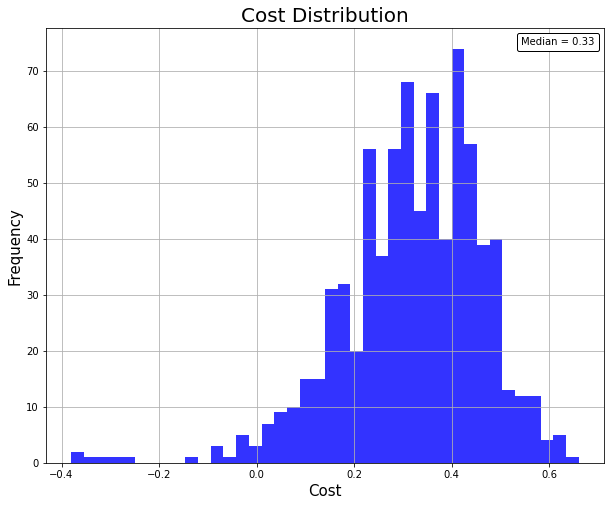

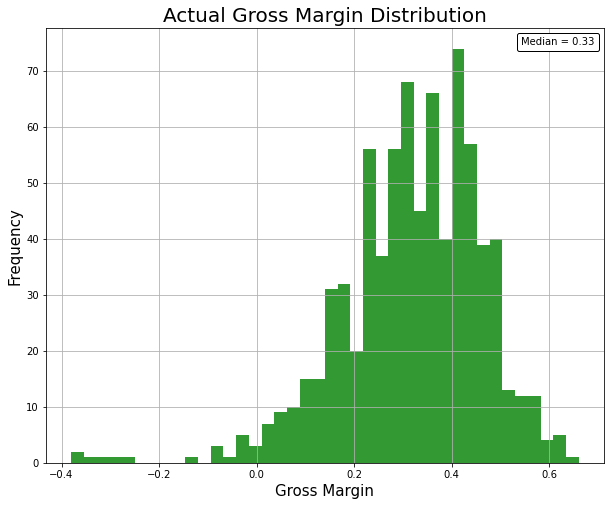

In [5]:
printhist(dfmerged_clean['GM'], 'Cost', 'Cost Distribution', 'blue')
printhist(dfmerged_clean['GM'], 'Gross Margin', 'Actual Gross Margin Distribution', 'green')